# How can we predict the sentiment associated with a customer interaction?

In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

rcParams['figure.figsize'] = 30, 60
%matplotlib inline

## Goals

After working through this case, you should be able to apply sentiment analysis to business problems. You will understand how to use text classification techniques to build a sentiment analysis model, and you'll be able to apply sentiment models to real-world data.

You will have gained experience using a number of different vectorization and model-building techniques, using popular Python libraries such as [scikit-learn](https://scikit-learn.org/stable/) and [gensim](https://github.com/RaRe-Technologies/gensim). You'll have used both count-based vectorizations and word embeddings, and you'll understand the pros and cons of each.

## Introduction

**Business Context.** You are a data scientist for a large e-commerce firm. You have tens of thousands of customers writing reviews on products each day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). You also have a customer support team which interacts with customers over call and messaging services. Your company also collects feedback about your customers' experiences with the website interaction after each purchase. Neither this feedback nor the messaging service have a rating number. The firm wants to quantify customer satisfaction coming from these non-rated interactions in order to help with further business decisions (e.g. determine how well your various customer service agents are doing).

**Business Problem.** Your task is to **build models which can identify the sentiment (positive or negative) of each of these non-rated interactions**.

**Analytical Context.** The data is a set of reviews in CSV file format. We will combine what we learned about text processing and classification models to develop algorithms capable of classifying interactions by sentiment.

The case is structured as follows: you will 1) read and analyze the input text data and the corresponding response variables (ratings); 2) perform basic pre-processing to prepare the data for modeling; 3) learn and apply various ways of featurizing the reviews text; and finally 4) build machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).

## Reading and performing basic analysis of the data

As usual the first step is to read the available data and perform some high-level analysis on it:

In [2]:
amazon_reviews = pd.read_csv('Reviews.csv')

# Selecting just 10,000 records for faster computation. 
# Feel free to comment the following line of code later, to build ML models using all the data.

amazon_reviews = amazon_reviews[:10000]
amazon_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Our dataset contains the following columns:

* **ID**: A unique ID for each row in the dataset
* **ProductId**: A reference to the product that the review is about
* **UserId**: A reference to the user who left the review
* **HelpfulnessNumerator**: The number of readers of the review who indicated that it was "helpful"
* **HelpfulnessDenominator**: The total number of people who gave an indication of whether or not the review was "helpful"
* **Score**: The star rating (1-5)
* **Time**: A Unix timestamp indicating when the review was created
* **Summary**: The user-written summary of what the review is about
* **Text**: The user-written review

Let's look at the distribution of number of words per review:

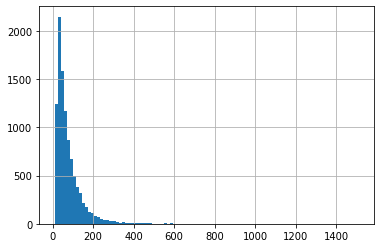

In [3]:
# Getting the number of words by splitting them by a space
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)

In [4]:
words_per_review.mean()

77.9028

Let's also look at the distribution of ratings:

In [5]:
amazon_reviews.Score.value_counts()

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64

In [6]:
percent_val = 100 * amazon_reviews.Score.value_counts()/amazon_reviews.shape[0]
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

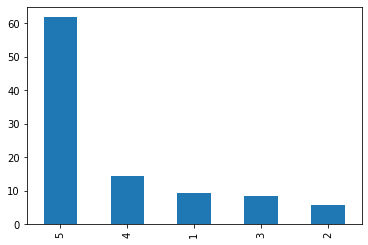

In [7]:
percent_val.plot.bar()

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

### Exercise 1:

Create a word cloud for the product reviews.

**Answer.**

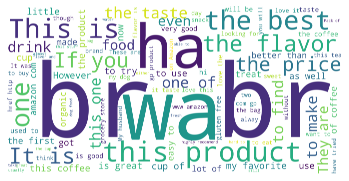

In [21]:
wc = WordCloud(background_color="white",width=800,height=400,scale=10,max_words=100).generate("".join(amazon_reviews["Text"]))

plt.figure()
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

--------

The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like good, love, best.

### Standardizing the ratings for sentiment analysis

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule: ratings of 4 or 5 will get mapped to 1 (indicating "positive"), ratings of 1 or 2 will get mapped to 0 (indicating "negative"), and ratings of 3 will get removed.

In [22]:
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3, 1, 0)
amazon_reviews['Sentiment_rating'].value_counts()

1    7616
0    2384
Name: Sentiment_rating, dtype: int64

In [23]:
# Removing neutral reviews 
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

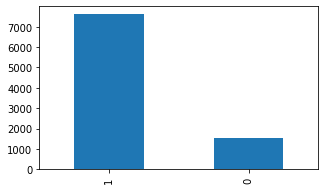

In [24]:
rcParams['figure.figsize'] = 5, 3
amazon_reviews.Sentiment_rating.value_counts().plot.bar()

## Pre-processing

As discussed previously, text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

1. converting words to lower/upper case
2. removing special characters
3. removing stopwords and high/low-frequency words
4. stemming/lemmatization

You should know most of these already, although number 4 is new. Let's proceed in order. Let's start by converting all of the words into a consistent case format, say lowercase:

In [25]:
amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())

C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
from nltk import word_tokenize
import nltk

nltk.download('punkt')

token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ", len(set(tokens_lower)))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro.ospina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of unique tokens then:  27504
Number of unique tokens now:  22470


The number of tokens has gone down by ~18% just from normalizing the case.

### Exercise 2:

Is removing special characters even a good idea? What are some examples of characters that would likely be safe to remove, and what are some that would not be?

**Answer.**

--------

For the sake of simplicity, we will proceed by removing all of the special characters; however, it pays to keep in mind that this is something to revisit depending on the results we get later. The following gives a list of all the special characters in our dataset:

In [ ]:
# Selecting non alpha numeric charactes that are not spaces
special_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# Getting list of list into a single list
flat_list = [item for sublist in special_chars for item in sublist]

# Unique special characters
print(set(flat_list))

Let's remove these special characters from the reviews:

In [ ]:
import re
review_backup = amazon_reviews.reviews_text_new.copy()
amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

We can see how our reviews change after removing these:

In [ ]:
print("Old Review:")
review_backup.values[6]

In [ ]:
print("New Review:")
amazon_reviews.reviews_text_new[6]

The number of unique tokens has dropped further:

In [ ]:
token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ", len(set(tokens)))

### Stopwords and high/low frequency words

As discussed before, stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them:

In [ ]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

### Exercise 3:

Find the high- and low-frequency words, which we will define as the 1% of words that occur most often in the reviews, as well as define the 1% of words that occur least often in the reviews (after adjusting for case and special characters).

**Answer.**

--------

In [ ]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

Stop words and high/low frequency words have now been added to `noise_words`, which will be removed from the reviews prior to training machine learning models. The common words are unlikely to be that useful as we expect them to appear about as often in positive and negative reviews. The uncommon words might be more meaningful and could in theory indicate the sentiment of the review, but as they appear so seldom our model would not be able to learn any meaning from them.</font>

### Stemming & lemmatization

Now we are ready for the last part of our pre-processing - **[stemming & lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)**.

Different forms of a word often communicate essentially the same meaning. For example, there’s probably no difference in intent between a search for `shoe` and a search for `shoes`. The same word may also appear in different tenses; e.g. "run", "ran", and "running". These syntactic differences between word forms are called **inflections**. In general, we probably want to treat inflections identically when featurizing our text.

Sometimes this process is nearly-reversible and quite safe (e.g. replacing verbs with their infinitive, so that "run", "runs", and "running" all become "run"). Other times it is a bit dangerous and context-dependant (e.g. replacing superlatives with their base form, so that "good", "better", and "best" all become "good"). The more aggressive you are, the greater the potential rewards and risks. For a very aggressive example, you might choose to replace "Zeus" and "Jupiter" with "Zeus" only; this might be OK if you are summarizing myths, confusing if you are working on astronomy, and disastrous if you are working on comparative mythology.

We won't get into the details of the differences between [stemming](http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer), [lemmatization](http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#module-nltk.stem.wordnet) and other types of text normalization here, but a careful introduction can be found at: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

nltk.download('wordnet')

from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

**Stemming algorithms** work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

On the other hand, **lemmatization** takes into consideration the morphological analysis of the words. So lemmatization takes into account the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [ ]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

It can be seen that we get a meaning root word from Lemmatizer while Stemmer just cuts out and extracts the first important part of the word.

## Building our machine learning model

Now we have cleaned-up versions of two very important pieces of data – the actual review text and its corresponding sentiment rating:

In [ ]:
amazon_reviews[['Text','Score','Sentiment_rating']].head(5)

The independent variables or model features are derived from the review text. Previously, we discussed how we can use n-grams to create features, and specifically how bag-of-words is the simplest interpretation of these n-grams, disregarding order and context entirely and only focusing on frequency/count. Let's use that as a starting point.

### Bag-of-words

`CountVectorizer` is a Python class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:

In [ ]:
# Creating a method for stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Let's use this to create a bag of words from the reviews, excluding the noise words we identified earlier:

In [ ]:
# Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

Once the bag of words is prepared, the dataset should be divided into training and test sets. We could also split the data after vectorizing it, but it's useful to split the data as early as possible in the process. This means that once we have generated our predictions, we can more easily compare them with the original texts, before they have been preprocessed and vectorized.

In [ ]:
reviews_train, reviews_test = train_test_split(amazon_reviews, test_size=0.2, random_state=0)

In [ ]:
X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

Note that we call `fit_transform` to vectorize our training set and `transform` to vectorize our test set. This builds the vectorization mappings *only* on data from the training set, which is a restriction we would be faced with in a real-world problem (not having access to testing data during training time).

Therefore, there may be some words in the test set which we don't know how to vectorize and they will be skipped.

In [ ]:
y_train_bow = reviews_train['Sentiment_rating']
y_test_bow = reviews_test['Sentiment_rating']

In [ ]:
y_test_bow.value_counts() / y_test_bow.shape[0]

The test data contains 84% positive sentiment reviews. The simplest prediction model we could think of would be one that predicts "positive" for every input. We would call this a "naive" model, and it makes for a useful baseline. In this case, such a model would get 84% accuracy, so we can consider this a baseline score that our machine learning model needs to beat.

### Applying logistic regression

Let's train the model on our training data and run the resulting model on our test data:

In [ ]:
# Training the model 
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predicting the output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

In [ ]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [ ]:
predictions = pd.DataFrame()
predictions['Text'] = reviews_test['Text']
predictions['Actual_Score'] = reviews_test['Score']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [ ]:
predictions.head(5)

In [ ]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

### Exercise 4:

In the `Predicted_probability` column you can see how confident the model was in its predictions, with probabilities very close to 0 being very confident negative sentiment predictions, and probabilities very close to 1 being very confident positive sentiment predictions.

Use this information to find the case where the model was *most confident* in predicting a review as having a negative sentiment when the actual score was positive.

Look at the review text and write a few sentences of analysis about why you think the model got it wrong.

**Answer.**

--------

### Exercise 5:

Modify the set of features in the model to include bigrams, trigrams, and 4-grams. Don't remove the noise words defined earlier before featurizing. (Hint: set `ngram_range=(1,4)`.) 

At the same time, experiment with hyperparameter tuning. Change the `C` value of the logistic regression classifier to 0.9.

**Answer.**

--------

### Exercise 6:

Perform random forests classification on our feature set just as we did above with logistic regression.

**Answer.**

--------

This is not quite as good as logistic regression. We can get the n-grams which were most important for the predictions as follows:

In [ ]:
feature_importances = pd.DataFrame(
    rf_model_all.feature_importances_,
    index=bow_counts.get_feature_names(),
    columns=['importance']
)

In [ ]:
feature_importances.sort_values(['importance'], ascending=False)[:10]

## TF-IDF model

Of course, bag-of-words are not the only way to featurize text. Another method, which we briefly touched upon before, is the **Term Frequency-Inverse Document Frequency (TF-IDF)** method. This evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is the product of two terms. The first computes the normalized Term Frequency (TF); i.e. the number of times a word appears in a document divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears:

<img src='tf-idf.png'>

Less formally, what does this mean?

* If a word appears very often in a specific document, it is likely to be significant.
* If a word appears very often throughout nearly all documents in the corpus, it is unlikely to be significant.
* Therefore, a word that appears often in one document but *rarely* in the rest of the corpus deserves special attention.

TF-IDF doesn't just count each word - it applies a weighting so that common words receive less attention and rare words receive more.

Let's re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [ ]:
# Create a vectorizer - we still feed in our stop words, although
# these are less relevant now as TF-IDF would weight them less 
# anyway.
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.reviews_text_new)
X_test_tfidf = tfidf_counts.transform(reviews_test.reviews_text_new)

### Applying logistic regression to TF-IDF features

Let's apply logistic regression to the features created from TF-IDF:

In [ ]:
# Create the classifier
lr_model_tf_idf = LogisticRegression(solver="liblinear")

# Train the classifier
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predict the results
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

Here we have attained an accuracy of 88% with TF-IDF as compared to 90% with 1-grams. It's hard to know exactly why this more sophisticated vectorizing algorithm leads to worse results, but it could be that penalising words that are common across the corpus leads to a disadvantage for this particular dataset. TF-IDF is often useful when the testing data is very different from the training data, allowing words that are only common in the training set to be deprioritized.

### Exercise 7:

Try increasing the accuracy of the model by 

* setting `ngram_range=(1,4)` in the Vectorizer
* not removing the noise words beforehand in the Vectorizer
* setting `C=10` in the LogisticRegression classsifier
* setting `penalty="l1"` in the LogisticRegression classifier

**Answer.**

--------

This is an improvement on our previous result, but we made four changes at the same time, so we don't know which ones helped and how much.
    
Trying different hyperparameters to improve your model is called **hyperparameter tuning** and is a huge field on its own. You can imagine how running this model 16 times, once with each possible configuration of hyperparamters we have tried, would already get kind of tricky to keep track, and this is only with 4 hyperparameters and two values for each! With 100s or 1000s of hyperparameters and 100s or 1000s of values for each, the total combinations grows very quickly.

To help with this, scikit-learn provides so-called "[grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)" functionality, where you can set up a pipeline and specify the ranges of hyperparmeters you want to "search". scikit-learn will try each combination and train and evaluate the model for each case, telling you which one performed the best.

We can also find our most important features again, as below:

In [ ]:
lr_weights = pd.DataFrame(
    list(
        zip(tfidf_counts.get_feature_names(), lr_model_tf_idf_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

In [ ]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

## Word embeddings model

The final type of featurization we will cover are **word embeddings**. This is a type of word representation that allows words with similar meaning to have a similar representation. By being pre-trained on external data, such as Wikipedia, word embeddings know when concepts are *semantically* related -- for example the vectors for "king" and "queen" would be located near each other, even though there is no syntactic or spelling similarity between these words.

It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems.
    
There are many datasets of pre-trained word embeddings that are freely available, or you can train your own. Some major breakthroughs in this area include [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), which became a poster child of NLP, and other embeddings approaches such as [Glove](https://nlp.stanford.edu/projects/glove/), [ELMo](https://allennlp.org/elmo) and [BERT](https://github.com/google-research/bert).

In the following image, each of the words have been represented in 2-dimensions for simplicity. In reality, embeddings are usually represented in at least 50 dimensions (often far more, actually). It can be clearly seen that words with similar context are grouped together – bathroom, kitchen, bathtub are grouped together, while microwave, refrigerator, oven form another group, etc.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

<img src='wembeddings.png'>

There are different methods to learn word embeddings - Word2Vec, GloVe, FastText. **Word2Vec** uses a shallow Neural Network and is of two types; _CBOW_ and _Skip Gram_. **GloVe** is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. **[fastText](https://fasttext.cc/)** is a library for learning of word embeddings and text classification created by Facebook's AI Research lab.

### Why use word embeddings over bag-of-words and TF-IDF?

Each word is represented by a real-valued vector, which generally has tens or hundreds of dimensions. This is in contrast to he thousands or millions of dimensions required for sparse word representations. Thus, word embeddings can drastically reduce the number of dimensions required for representing a text document:

In [ ]:
import gensim

In [ ]:
# Loading a pre-trained glove word embedding that is trained on a Twitter dataset 
# This word embedding is 200 dimensional, meaning that each word is represented
# by a 200 dimensional vector.

model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(), 'glove.twitter.27B.200d_out.txt'),
    binary=False,
    unicode_errors='ignore'
)

We had approximately 18,000 distinct tokens for 1-gram features in the bag-of-words representation, yet will only have 200 dimensions in this word embedding. This is a huge difference!

Moreover, word embeddings capture the context and semantics of the sentences since each word vector representation is itself based on its contextual meaning.

Below is the vector representation for "food" and "great":

In [ ]:
print("The embedding for food is", len(model['food']), "dimensional")

model['food']

In [ ]:
print("The embedding for great is", len(model['great']), "dimensional")

model['great']

As we discussed, the power of word embeddings is that that words that have a similar meaning are closer together in vector space. We can demonstrate this by looking at the cosine distance between some pairs of words as follows:

In [ ]:
def print_similarity(word1, word2, model):
    v1 = model[word1]
    v2 = model[word2]
    similarity = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    print(f"{word1} and {word2} are {round(similarity * 100)}% similar")

print_similarity("cat", "dog", model)
print_similarity("good", "bad", model)
print_similarity("great", "good", model)
print_similarity("grass", "model", model)

Here, "similar meaning" is loosely defined as "used in similar contexts". Because there are many examples such as "I stroked my cat" and "I stroked my dog" where these words are used in similar contexts, they are regarded as very similar. There are also many sentences where "good" and "bad" can be interchanged and the sentence can remain valid, so although we regard these as "opposite" our model will regard them as similar. "grass" and "model" have nearly nothing to do with each other, so they are very far apart.

To find the vector for an entire review, we get the vector for each word in the review separately and take a simple average.

### Exercise 8:

Calculate the vector for every single review in the dataset.

**Answer.**

--------

Loading your own word vectors is great to understand how they work, but higher-level libraries that abstract away code like that shown above also exist. In industry, a widely used NLP library is [SpaCy](https://spacy.io/). This library allows you efficiently extract the word embeddings from texts and carry out high-level operations on them.

Let's convert the list of vector representations for each review into a DataFrame and split it into train and test sets:

In [ ]:
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)

In [ ]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed =  train_test_split(
    embedding_data,
    amazon_reviews.Sentiment_rating,
    test_size=0.2,
    random_state=0
)

Let's now apply logistic regression to our word embeddings representation:

In [ ]:
lr_model = LogisticRegression(penalty="l1", C=10, solver="liblinear")
lr_model.fit(X_train_embed, y_train_embed)
test_pred_lr_prob = lr_model.predict_proba(X_test_embed)
test_pred_lr_all = lr_model.predict(X_test_embed)

print("F1 score: ", f1_score(y_test_embed, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_embed, test_pred_lr_all)*100)

Unfortunately, this is not as good as either the bag-of-words or TF-IDF representations. Furthermore, although word embeddings was really effective at reducing the overall number of dimensions, it suffers from the problem of interpretability. This means that it is very hard for us to even diagnose what is causing its sub-par performance.

However remember how "good" and "bad" were close together in vector space? This is one reason why word embeddings may not perform as well for sentiment analysis in smaller datasets - word embeddings are good at using "knowledge" from the external world (latent in the pre-trained embeddings) to inferr additional information about a smaller dataset, but in the case of sentiment analysis this might do more harm than good by conflating "similar" words that are actually very separate for a sentiment analysis task.

In our case, creating features using TF-IDF got us an accuracy of 92% with very interpretable features. This is a good combination and so we deem this the best model for us here.

Note that for a real experiment, we would have split our dataset into *three* parts, not just two. When running an experiment multiple times with different parameters, it's almost certain that some results will be better simply by chance, and it's bad science to select the best performing model after dozens or hundreds of runs.
    
To avoid this problem, the data should be split into "training", "test", and "validation" sets. The "test" set should be set aside at the start of the experiment and never looked at. The model should be tuned by using the "validation" set.

Only once the experimenter is happy with the model by improving the performance on the validation set should the model be run on the test set, and those final results taken as the final results of the experiment. 

You can read more details about this methodology [here](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).


## Conclusions

In this case, we cleaned up and featurized an Amazon reviews dataset and built some classification models on these featurizations to predict sentiment. We saw that bag-of-words and TF-IDF both gave interpretable features, while word embeddings did not really. Through increasing the set of n-grams we used from 1-grams to up to 4-grams, we were able to get our logistic regression model accuracy up to 92%.

## Takeaways

Building machine learning models on text is a very involved discipline. Some important things of note are as follows:

1. Although there are different types of pre-processing involved in textual data, not everything has to be applied in each case. For instance, when dealing with text messages, special characters might represent important information and need not be removed. Furthermore, upper case may mean someone is angry and represents shouting, so uppercase and lowercase may represent valuable information. In other situations, it's more valuable to normalize these.

2. Hyperparameter tuning in machine learning models is a very important step and while default hyperparameters work well in many cases, extra performance can often be gained through tuning these. Different sets of parameters have to be tried to see what contributes to the best model.

3. Every NLP classification task is different, but the process to be followed is similar to what we did in this case: wrangle the data -> create features from text -> train models -> evaluate models.